In [5]:
from matplotlib import pyplot as plt
import networkx as nx
import numpy as np
import math
np.random.seed(0)

In [6]:
#Each package has on origin, a destination, and a current position (a city or a road)
class Package:
    def __init__(self, origin_index, destination_index, current_position):
        self.destination_index = destination_index
        self.origin_index = origin_index
        self.current_position = origin_index

    def set_destination(self, destination_index):
        self.destination_index = destination_index

    def get_destination(self):
        return self.destination_index

    def set_origin(self, origin_index):
        self.origin_index = origin_index

    def get_origin(self):
        return self.origin_index

    def set_current_position(self, current_position):
        self.current_position = current_position

    def get_current_position(self):
        return self.current_position

In [14]:
#The network class:
class Delivery_Network:

    '''
    The network has the following attributes:
     - network_size: The number of cities
     - max_road_capacity: The theoretical maximum number of packages that can travel on the same road at once.
        Each road has its own maximum capacity, typically smaller than max_road_capacity
     - max_distance: The theoretical maximum distance between two cities
     - m: The m variable in the initialization of the Barabasi-Albert graph. It indicates how many connections a newly added city has.
     - max_packages: The theoretical maximum number of packages that can stay in a city at once.
        Each city has its own maximum capacity, typically smaller than max_packages
     - time: Keeps track of the amount of steps that have passed
     - active_nodes_list: Contains a list of the "active" nodes - the ones that have not yet reached their maximum capacity
     - active_edges_list_small_large: Contains a list of the "active" edges - the ones that have not yet reached their maximum capacity,
        in the direction from the smaller index to the larger one.
     - active_edges_list_large_small: Contains a list of the "active" edges - the ones that have not yet reached their maximum capacity,
        in the direction from the larger index to the smaller one.
     - delivered: Contains a list of the packages that have reached their final destination,
     - total_num_packages: The total number of packages in the network.
    '''

    def __init__(self, network_size=10, max_road_capacity = 10, m = 3, max_distance = 5, max_packages = 50, time = 0, active_nodes_list = [], active_edges_list_small_large = [], active_edges_list_large_small = [], delivered = 0, total_num_packages = 0):
        self.network_size = network_size
        self.max_road_capacity = max_road_capacity
        self.max_distance = max_distance
        self.m = m
        self.max_packages = max_packages
        self.time = time
        self.active_edges_list_small_large = active_edges_list_small_large
        self.active_edges_list_large_small = active_edges_list_large_small
        self.active_nodes_list = active_nodes_list
        self.delivered = delivered
        self.total_num_packages = total_num_packages

    def get_delivered(self):
        return self.delivered

    def get_edges(self):
        return self.graph.edges

    def get_nodes(self):
        return self.graph.nodes

    def get_total(self):
        return self.total_num_packages

    def get_time(self):
        return self.time

    #This function doubles the maximum road capacity in both direction of a specified road
    def double_max_road_capacity(self, node1, node2):
        if (node1, node2) in self.graph.edges:
            self.graph.edges[(node1, node2)]['max_road_capacity_small_large'] = 2*self.graph.edges[(node1, node2)]['max_road_capacity_small_large']
            self.graph.edges[(node1, node2)]['max_road_capacity_large_small'] = 2*self.graph.edges[(node1, node2)]['max_road_capacity_large_small']
        else:
            raise Exception('ERROR DOUBLING MAX ROAD CAPACITY!!!')

    #This function doubles the maximum city capacity to store packages of a specified city
    def double_max_num_packages(self, node1):
        if node1 in self.graph.nodes:
            self.graph.nodes[node1]['max_num_packages'] = 2*self.graph.nodes[node1]['max_num_packages']
        else:
            raise Exception('ERROR DOUBLING MAX NUM PACKAGES!!!')

    def initialize(self, seed_for_network_structure, saturation_level):
        #The network has the structure of a Barabasi-Albert graph
        self.graph = nx.barabasi_albert_graph(self.network_size, self.m, seed = seed_for_network_structure)
        print ("aaaaa", self.graph.edges)
        print ("bbbbb", self.graph.edges[(0,3)])
        print ("ccccc", self.graph.edges[(3,0)])
        print ("aaaaa", self.graph.edges)
        print ("bbbbb", self.graph.edges[(0,3)])
        print ("ccccc", self.graph.edges[(3,0)])
        nodes_list = list(self.graph.nodes)
        edges_list = list(self.graph.edges)

        #Initially all nodes and edges are active
        self.active_nodes_list = [i for i in nodes_list]
        self.active_edges_list_small_large = [i for i in edges_list]
        self.active_edges_list_large_small = [(i[1],i[0]) for i in edges_list]

        #This function removes a node from a list
        def remove_node(nodes_list, to_remove):
            copy_nodes_list = [i for i in nodes_list]
            copy_nodes_list.remove(to_remove)
            return copy_nodes_list

        for edge in self.graph.edges:
            #The minimum road capacity in each direction is 5, and the capacities are assigned at random
            self.graph.edges[edge]['max_road_capacity_small_large'] = np.random.randint(5,self.max_road_capacity)
            self.graph.edges[edge]['max_road_capacity_large_small'] = np.random.randint(5,self.max_road_capacity)
            #The minimum distance between two cities is 2, and the distances are assigned at random
            self.graph.edges[edge]['distance'] = np.random.randint(2,self.max_distance)
            #Each edge has a list of the packages that travel along it in each direction
            self.graph.edges[edge]['packages_small_large'] = []
            self.graph.edges[edge]['packages_large_small'] = []

        #The node capacity to store packages is determined based on the connectivity of the node - the more connected it is,
        #the more packages it can store. The expected max_num_packages is 0.8 times the proportion of connected cities to it
        #times the theoretical maximum.
        for node in self.graph.nodes:
            self.graph.nodes[node]['max_num_packages'] = np.random.binomial(int(round((self.graph.degree(node)/float(self.network_size-1))*self.max_packages)), 0.8)

        #Initializing the packages:
        #Each city has a saturation level, which determines what proportion of the city's max capacity will be filled with packages.
        #Each package's final destination is determined at random from the remaining nodes.
        for node in self.graph.nodes:
            self.graph.nodes[node]['packages'] = []
            modified_nodes = remove_node(nodes_list, node)
            for package_index in range(int(round(self.graph.nodes[node]['max_num_packages']*saturation_level))):
                self.graph.nodes[node]['packages'].append(Package(node, np.random.choice(modified_nodes), node))

        #Calculating the total number of packages in the network:
        self.total_num_packages = sum(len(self.graph.nodes[node]['packages']) for node in nodes_list)
        print ("Total number of packages:", self.total_num_packages)

        #For the layout:
        self.layout = nx.spring_layout(self.graph)

        #Printing:
        print ("----------")
        print ("nodes_list=", nodes_list)
        print ("edges_list=", edges_list)
        for node in self.graph.nodes:
            #print "Node", node, "has max_num_packages=", self.graph.nodes[node]['max_num_packages']
            #print "Node", node, "has this many packages:", len(self.graph.nodes[node]['packages'])
            #for package in self.graph.nodes[node]['packages']:
                #print "The characteristics of package", package, "are origin:", package.get_origin(), ", destination:", package.get_destination(), ", and curr_position:", package.get_current_position()
            pass
        for edge in self.graph.edges:
            #print "Edge", edge, "has max_road_capacity_small_large=", self.graph.edges[edge]['max_road_capacity_small_large']
            #print "Edge", edge, "has max_road_capacity_large_small=", self.graph.edges[edge]['max_road_capacity_large_small']
            #print "Edge", edge, "has distance=", self.graph.edges[edge]['distance']
            #print "Edge", edge, "has packages:", self.graph.edges[edge]['packages_small_large'], "and", self.graph.edges[edge]['packages_large_small']
            pass
        print ("----------")
        
    #The update function that exectues at each step after initialization
    def update(self):

        self.time += 1
        nodes_list = list(self.graph.nodes)
        edges_list = list(self.graph.edges)

        #This function uses networkx's capabilities to find the shortest path between any two nodes and its distance
        def find_shortest_path(node1, node2, number):
            p = list(nx.shortest_simple_paths(self.graph, node1, node2, weight = 'distance'))
            return p[number], len(p)
        
        #The function that sends a package from a city to a road
        def send_package_from_city(package):
            if package.destination_index != package.current_position:

                #Find shortest path and check if the first edge is active
                count = 0    #counts the number of shortest paths tried
                while True:
                    try_path = find_shortest_path(package.current_position, package.destination_index,count)[0]
                    success = True

                    if try_path[0] > try_path[1]:
                        if (try_path[0],try_path[1]) not in self.active_edges_list_large_small:
                            success = False
                    if try_path[0] < try_path[1]:
                        if (try_path[0],try_path[1]) not in self.active_edges_list_small_large:
                            success = False

                    if success == True:
                        #The edge is active
                        break
                    count += 1

                    if count >= find_shortest_path(package.current_position, package.destination_index,count-1)[1]:
                        #If all shortest paths have been tried and failed, we cannot send the package
                        break

                if success==False:
                    #print "Could not send package from", package.current_position, "to", package.destination_index
                    pass

                else:
                    #If we found a path to send the package on.
                    #Setting the current position as a triple: the two ends of the corresponding edge,
                    #and the position on that edge that the package currently occupies
                    package.set_current_position((try_path[0],try_path[1],0))

                    #If the package fills up the capacity of the edge, we need to remove the edge from the list of active edges.
                    #We then append the package to the list of packages on that road
                    if try_path[0]>try_path[1] and len(self.graph.edges[(try_path[1], try_path[0])]['packages_large_small']) == self.graph.edges[(try_path[1], try_path[0])]['max_road_capacity_large_small']-1:
                        self.active_edges_list_large_small.remove((try_path[0], try_path[1]))
                        self.graph.edges[(try_path[1], try_path[0])]['packages_large_small'].append(package)

                    elif try_path[0]<try_path[1] and len(self.graph.edges[(try_path[0], try_path[1])]['packages_small_large']) == self.graph.edges[(try_path[0], try_path[1])]['max_road_capacity_small_large']-1:
                        self.active_edges_list_small_large.remove((try_path[0], try_path[1]))
                        self.graph.edges[(try_path[0], try_path[1])]['packages_small_large'].append(package)

                    #Otherwise, we just append the package to the list of packages on that road
                    elif try_path[0]>try_path[1]:
                        self.graph.edges[(try_path[1], try_path[0])]['packages_large_small'].append(package)
                    else:
                        self.graph.edges[(try_path[0], try_path[1])]['packages_small_large'].append(package)

                    #If the release of the package from the city made it active again, we should reflect that
                    if try_path[0] not in self.active_nodes_list:
                        self.active_nodes_list.append(try_path[0])
                    self.graph.nodes[try_path[0]]['packages'].remove(package)
            #If the destionation equals the current position, then something is wrong
            else:
                raise Exception('TRYING TO SEND A PACKAGE THAT IS ALREADY WHERE IT NEEDS TO BE!!!')


        #The function that sends a package from a road to a city
        def receive_package_from_road(package):
            if package.current_position[2] != self.graph.edges[(package.current_position[0],package.current_position[1])]['distance']-1:
                raise Exception('ERROR RECEIVING PACKAGE!!!')
            else:
                #If the package is indeed arriving at the destination:
                if package.current_position[1] in self.active_nodes_list:
                    #The destination node should be active
                    self.graph.nodes[package.current_position[1]]['packages'].append(package)

                    if len(self.graph.nodes[package.current_position[1]]['packages']) == self.graph.nodes[package.current_position[1]]['max_num_packages']:
                        #If the addition of the package to the city fills up the capacity, we must remove the city from the list of active nodes
                        self.active_nodes_list.remove(package.current_position[1])

                    if package.current_position[0] > package.current_position[1]:
                        if len(self.graph.edges[(package.current_position[1], package.current_position[0])]['packages_large_small']) == self.graph.edges[(package.current_position[1], package.current_position[0])]['max_road_capacity_large_small']:
                            #If the release of the package from the road makes it active again, we need to reflect this
                            self.active_edges_list_large_small.append((package.current_position[0], package.current_position[1]))
                        self.graph.edges[(package.current_position[1], package.current_position[0])]['packages_large_small'].remove(package)

                    if package.current_position[0] < package.current_position[1]:
                        if len(self.graph.edges[(package.current_position[0], package.current_position[1])]['packages_small_large']) == self.graph.edges[(package.current_position[0], package.current_position[1])]['max_road_capacity_small_large']:
                            #If the release of the package from the road makes it active again, we need to reflect this
                            self.active_edges_list_small_large.append((package.current_position[0], package.current_position[1]))
                        self.graph.edges[(package.current_position[0], package.current_position[1])]['packages_small_large'].remove(package)

                    #The current position of the package is now the index of the city at which it arrived
                    package.set_current_position(package.current_position[1])
                else:
                    #The destination node is not active, so we do nothing and wait
                    #print "Package", package.current_position, "waiting to enter because destination is not active!", "Distance=", self.graph.edges[(package.current_position[0],package.current_position[1])]['distance']
                    pass

        #This function increases the distance traveled by a package on a road
        def travel(package):
            package.set_current_position((package.current_position[0],package.current_position[1],package.current_position[2]+1))




        #For each node, we send the packages from that node (if possible):
        for a_node in nodes_list:
            for package in self.graph.nodes[a_node]['packages']:
                send_package_from_city(package)

        #For each edge, we either let the packages travel, or deliver them to their destinations
        for an_edge in edges_list:
            for package in self.graph.edges[an_edge]['packages_small_large']:
                #If the package's current position is less than the distance minus 1, just travel
                if package.current_position[2] < self.graph.edges[(package.current_position[0],package.current_position[1])]['distance']-1:
                    travel(package)

                #If the package's current position equals the distance minus 1, then we must try to deliver it to the node
                else:
                    receive_package_from_road(package)

                    #If the package has reached its final destination, increase number of delivered and remove it from the node
                    if type(package.current_position) == type(1):
                        if package.destination_index == package.current_position:

                            self.delivered += 1
                            if package.current_position not in self.active_nodes_list:
                                #If the release of the delivered package makes the city active again, we must reflect that
                                self.active_nodes_list.append(package.current_position)
                            #Removing the package from the city
                            self.graph.nodes[package.current_position]['packages'].remove(package)

            for package in self.graph.edges[an_edge]['packages_large_small']:
                #If the package's current position is less than the distance minus 1, just travel
                if package.current_position[2] < self.graph.edges[(package.current_position[1],package.current_position[0])]['distance']-1:
                    travel(package)

                #If the package's current position equals the distance minus 1, then we must try to deliver it to the node
                else:
                    receive_package_from_road(package)

                    #If the package has reached its final destination, increase number of delivered and remove it from the node
                    if type(package.current_position) == type(1):
                        if package.destination_index == package.current_position:

                            self.delivered += 1
                            if package.current_position not in self.active_nodes_list:
                                #If the release of the delivered package makes the city active again, we must reflect that
                                self.active_nodes_list.append(package.current_position)
                            #Removing the package from the city
                            self.graph.nodes[package.current_position]['packages'].remove(package)

    #This function allows us to visualize the network
    def observe(self):
        plt.clf()
        nx.draw(
            self.graph, pos=self.layout, with_labels=False,
            node_color = [len(self.graph.nodes[i]['packages'])/float(self.graph.nodes[i]['max_num_packages']) for i in self.graph.nodes],
            edge_color = [max(0.08, len(self.graph.edges[i, j]['packages_large_small'])/float(self.graph.edges[i, j]['max_road_capacity_large_small']), len(self.graph.edges[i, j]['packages_small_large'])/float(self.graph.edges[i, j]['max_road_capacity_small_large'])) for i, j in self.graph.edges],
            cmap=plt.cm.Greys, edge_cmap=plt.cm.binary, edge_vmin=0., edge_vmax=1., alpha=1., vmin=0., vmax=1.
            )
        labels={}
        for i in range(len(self.graph.nodes)):
            labels[i]=i
        nx.draw_networkx_edge_labels(self.graph, self.layout, edge_labels = nx.get_edge_attributes(self.graph,'distance'), font_size = 7)
        nx.draw_networkx_labels(self.graph,self.layout,labels,font_size=12, font_color = 'GREEN')
        plt.title('Road Network')
        plt.show()

aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
Total number of packages: 166
----------
nodes_list= [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
edges_list= [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
----------


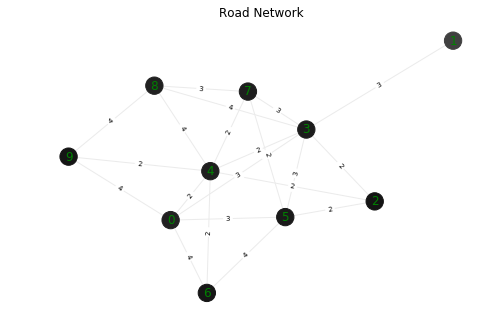

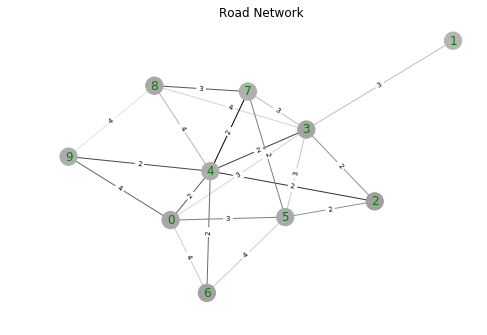

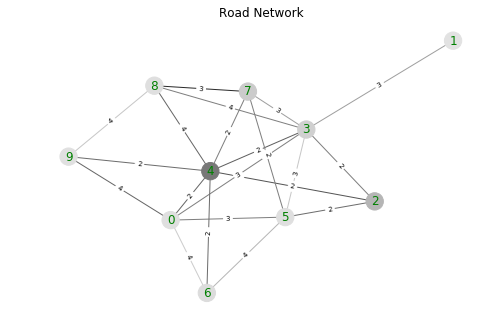

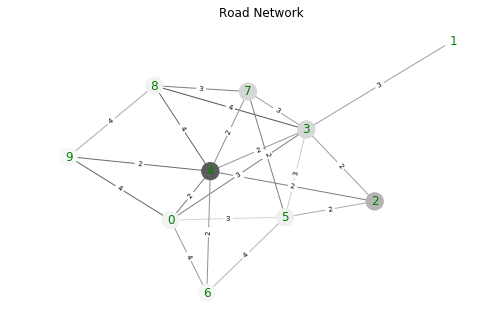

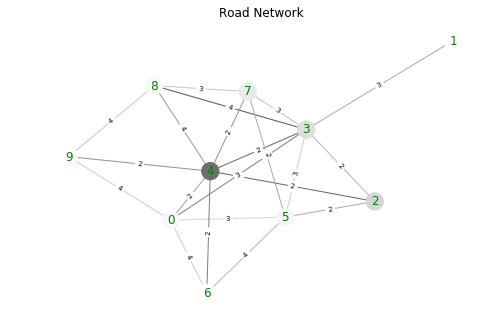

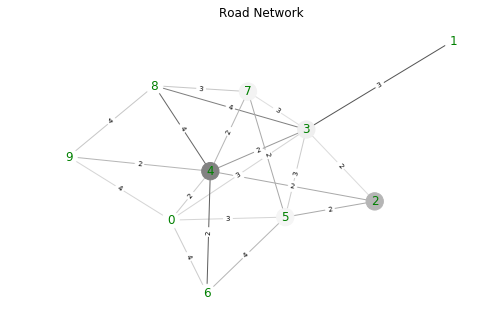

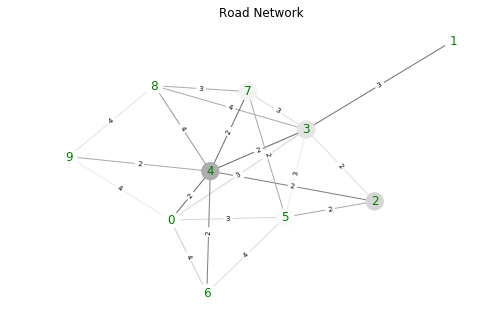

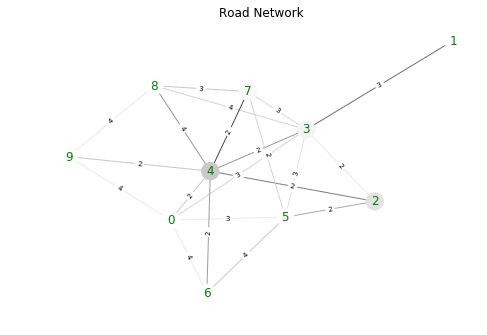

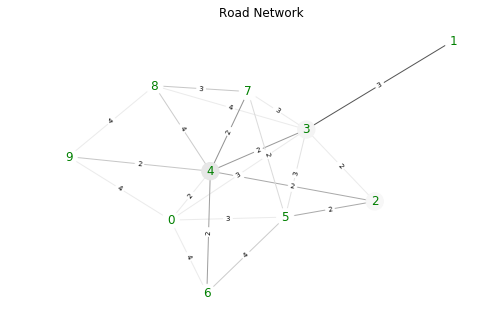

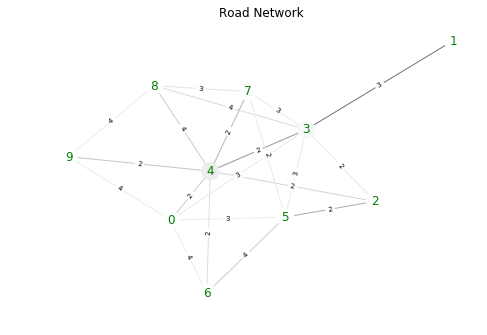

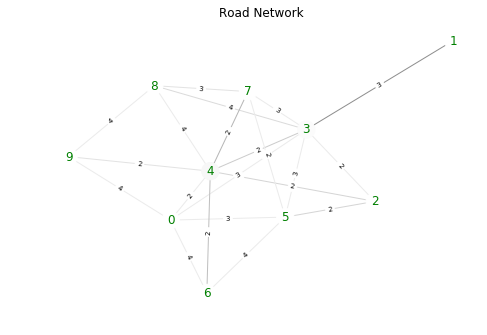

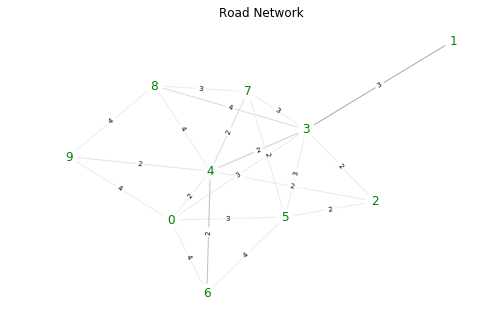

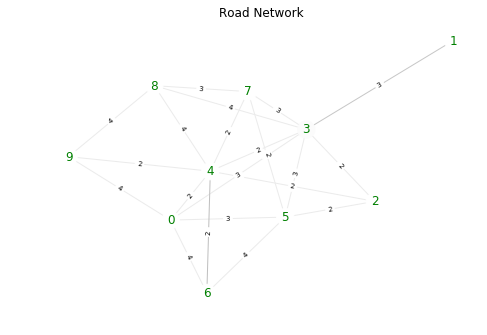

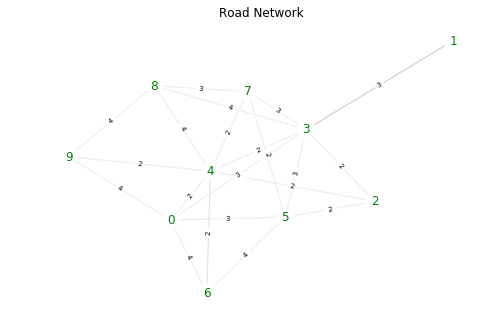

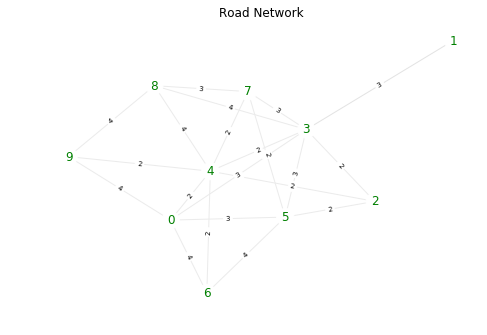

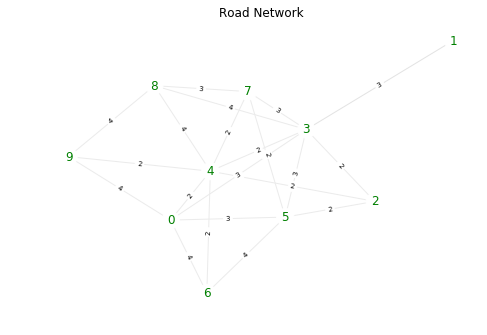

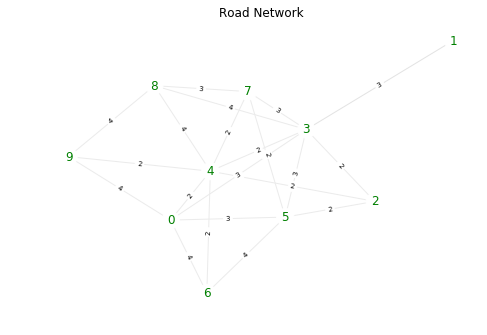

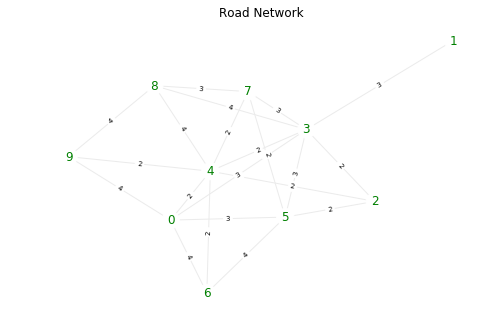

SUCCESS in 17 steps


In [15]:
#Defining the network and visualizing the initial state:
sim = Delivery_Network()
saturation = 0.9
sim.initialize(0,saturation)
plt.figure()
sim.observe()

#Updating the network state until all packages are delivered and visualizing the states:
while True:
    if sim.get_total() == sim.get_delivered():
        print ("SUCCESS in", sim.get_time(), "steps")
        break
    sim.update()
    plt.figure()
    sim.observe()

aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
Total number of packages: 176
----------
nodes_list= [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
edges_list= [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
----------


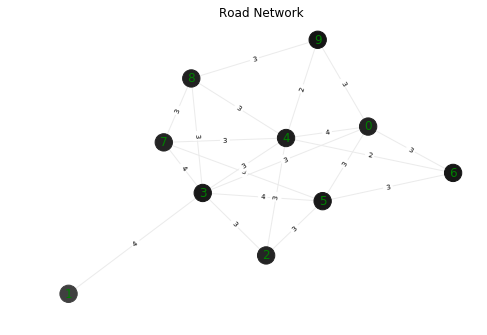

edge= (3, 4) and j= 0


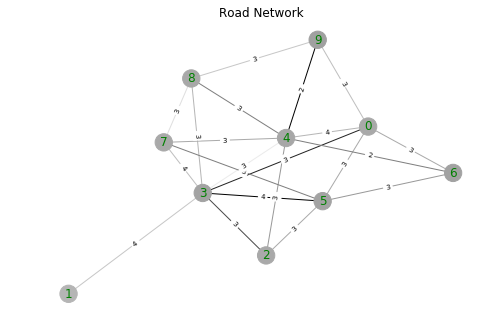

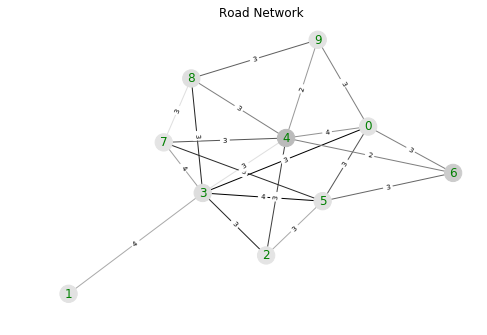

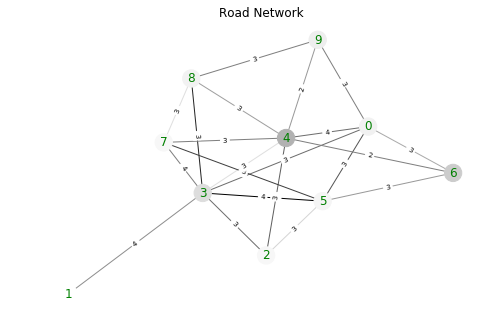

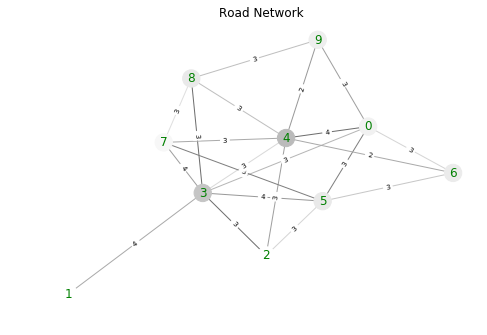

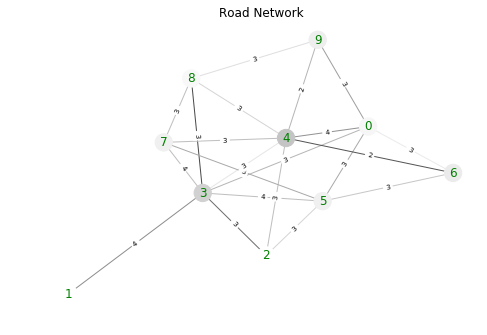

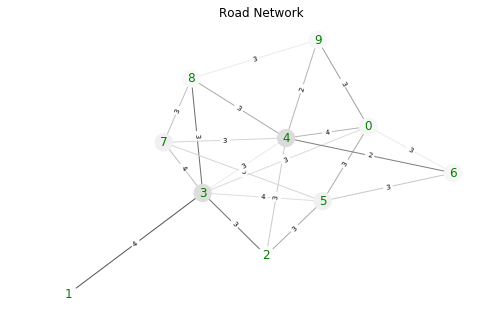

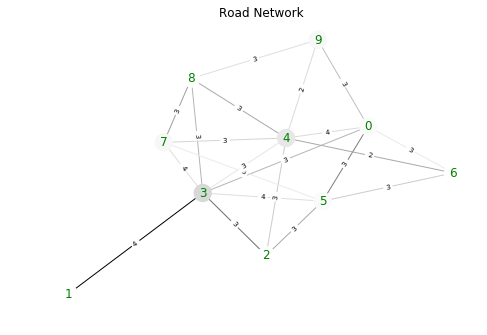

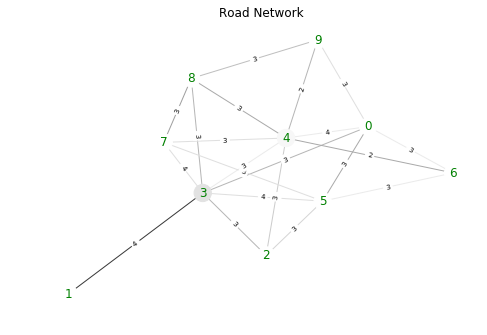

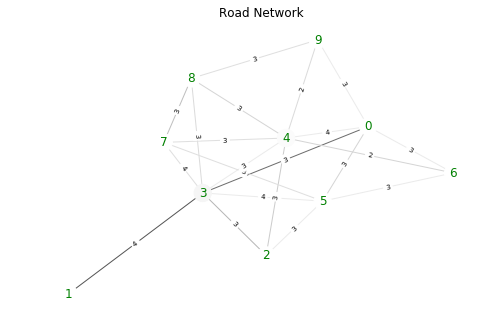

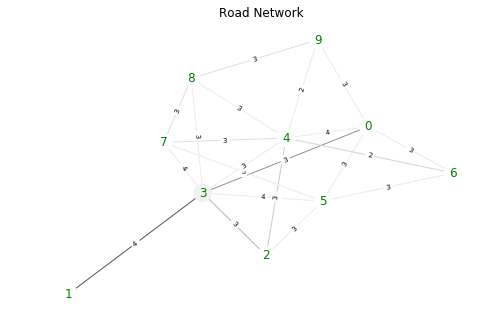

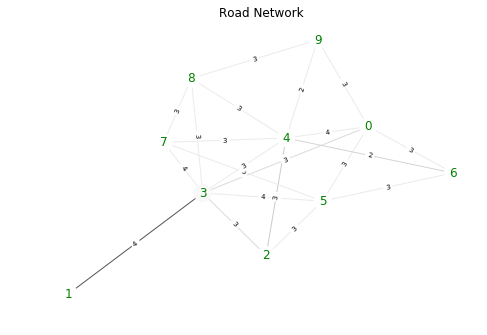

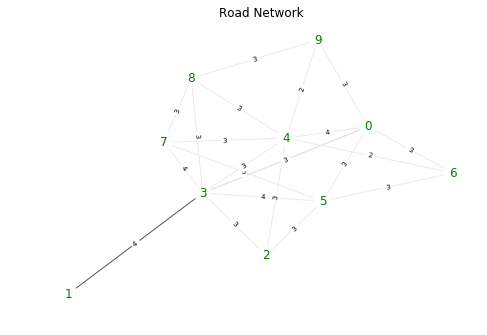

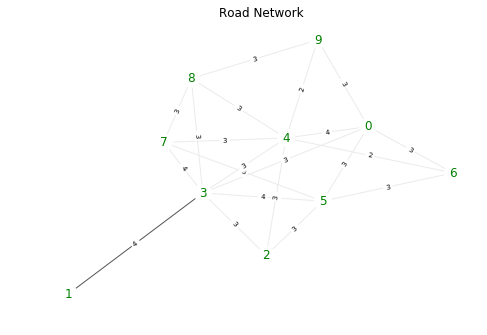

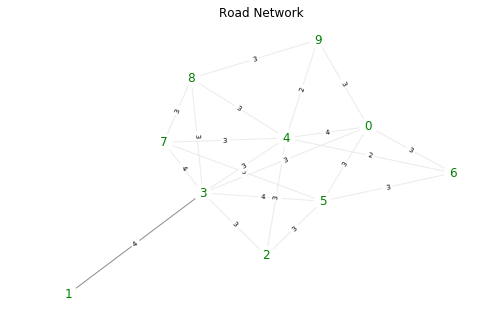

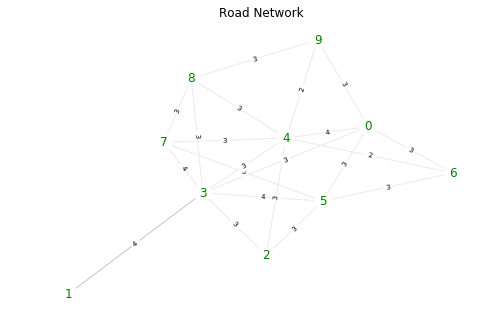

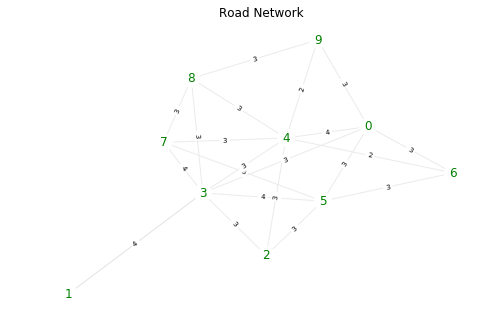

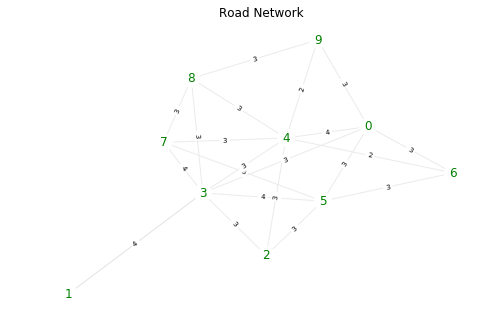

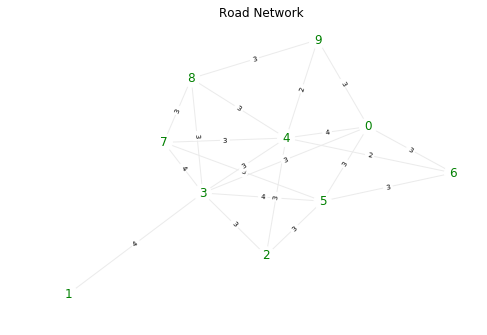

SUCCESS in 18 steps
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
Total number of packages: 166
----------
nodes_list= [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
edges_list= [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
----------
edge= (3, 4) and j= 1


SUCCESS in 27 steps
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
Total number of packages: 176
----------
nodes_list= [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
edges_list= [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
----------
edge= (3, 4) and j= 2


SUCCESS in 16 steps
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
Total number of packages: 163
----------
nodes_list= [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
edges_list= [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
----------
edge= (3, 4) and j= 3


SUCCESS in 16 steps
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
Total number of packages: 166
----------
nodes_list= [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
edges_list= [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
----------
edge= (3, 4) and j= 4


SUCCESS in 15 steps
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
Total number of packages: 168
----------
nodes_list= [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
edges_list= [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
----------
edge= (3, 4) and j= 5


SUCCESS in 17 steps
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
Total number of packages: 167
----------
nodes_list= [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
edges_list= [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
----------
edge= (3, 4) and j= 6


SUCCESS in 17 steps
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
Total number of packages: 157
----------
nodes_list= [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
edges_list= [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
----------
edge= (3, 4) and j= 7


SUCCESS in 21 steps
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
Total number of packages: 164
----------
nodes_list= [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
edges_list= [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
----------
edge= (3, 4) and j= 8


SUCCESS in 17 steps
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
Total number of packages: 171
----------
nodes_list= [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
edges_list= [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
----------
edge= (3, 4) and j= 9


SUCCESS in 21 steps
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
Total number of packages: 165
----------
nodes_list= [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
edges_list= [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
----------
edge= (3, 4) and j= 10


SUCCESS in 16 steps
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
Total number of packages: 173
----------
nodes_list= [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
edges_list= [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
----------
edge= (3, 4) and j= 11


SUCCESS in 17 steps
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
Total number of packages: 164
----------
nodes_list= [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
edges_list= [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
----------
edge= (3, 4) and j= 12


SUCCESS in 20 steps
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
Total number of packages: 171
----------
nodes_list= [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
edges_list= [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
----------
edge= (3, 4) and j= 13


SUCCESS in 19 steps
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
Total number of packages: 162
----------
nodes_list= [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
edges_list= [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
----------
edge= (3, 4) and j= 14


SUCCESS in 23 steps
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
Total number of packages: 170
----------
nodes_list= [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
edges_list= [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
----------
edge= (3, 4) and j= 15


SUCCESS in 21 steps
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
Total number of packages: 170
----------
nodes_list= [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
edges_list= [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
----------
edge= (3, 4) and j= 16


SUCCESS in 17 steps
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
Total number of packages: 167
----------
nodes_list= [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
edges_list= [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
----------
edge= (3, 4) and j= 17


SUCCESS in 15 steps
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
Total number of packages: 172
----------
nodes_list= [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
edges_list= [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
----------
edge= (3, 4) and j= 18


SUCCESS in 21 steps
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
Total number of packages: 171
----------
nodes_list= [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
edges_list= [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
----------
edge= (3, 4) and j= 19


SUCCESS in 21 steps
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
Total number of packages: 173
----------
nodes_list= [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
edges_list= [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
----------
edge= (3, 4) and j= 20


SUCCESS in 19 steps
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
Total number of packages: 179
----------
nodes_list= [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
edges_list= [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
----------
edge= (3, 4) and j= 21


SUCCESS in 19 steps
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
Total number of packages: 174
----------
nodes_list= [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
edges_list= [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
----------
edge= (3, 4) and j= 22


In [16]:
#Obtaining data for decision-making:

#------------EDGES------------:

#Number of simulations used
num_of_simulations = 30
saturation = 0.9
averages = []
conf_intervals = []

#Upgrading all the edges in the list, by multiplying their respective capacities by 8
for edge_to_upgrade in [(3,4)]:
    average_steps = []
    for j in range(num_of_simulations):
        if j==0:

            #Visualize the first simulation only
            sim = Delivery_Network()
            sim.initialize(0,saturation)
            sim.double_max_road_capacity(edge_to_upgrade[0], edge_to_upgrade[1])
            sim.double_max_road_capacity(edge_to_upgrade[0], edge_to_upgrade[1])
            sim.double_max_road_capacity(edge_to_upgrade[0], edge_to_upgrade[1])
            plt.figure()
            sim.observe()
            print ("edge=", edge_to_upgrade, "and j=", j)

            #Running the simulation
            while True:
                if sim.get_total()==sim.get_delivered():
                    print ("SUCCESS in", sim.get_time(), "steps")
                    average_steps.append(sim.get_time())
                    break
                sim.update()
                plt.figure()
                sim.observe()

        else:
            sim = Delivery_Network()
            sim.initialize(0,saturation)
            sim.double_max_road_capacity(edge_to_upgrade[0], edge_to_upgrade[1])
            sim.double_max_road_capacity(edge_to_upgrade[0], edge_to_upgrade[1])
            sim.double_max_road_capacity(edge_to_upgrade[0], edge_to_upgrade[1])
            print ("edge=", edge_to_upgrade, "and j=", j)

            #Running the simulation
            while True:
                if sim.get_total()==sim.get_delivered():
                    print ("SUCCESS in", sim.get_time(), "steps")
                    average_steps.append(sim.get_time())
                    break
                sim.update()

    #Results:
    print ("On average:", sum(average_steps)/float(num_of_simulations), "steps are needed when we upgrade edge", edge_to_upgrade, "!")
    averages.append([edge_to_upgrade, sum(average_steps)/float(num_of_simulations)])
    conf_intervals.append([edge_to_upgrade, [sum(average_steps)/float(num_of_simulations) - 1.96*np.std(average_steps)/float(np.sqrt(30)), sum(average_steps)/float(num_of_simulations) + 1.96*np.std(average_steps)/float(np.sqrt(30))]])


print ("Averages:")
print (averages)
print (" ")
print ("Confidence intervals:")
print (conf_intervals)

aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
Total number of packages: 167
----------
nodes_list= [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
edges_list= [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
----------


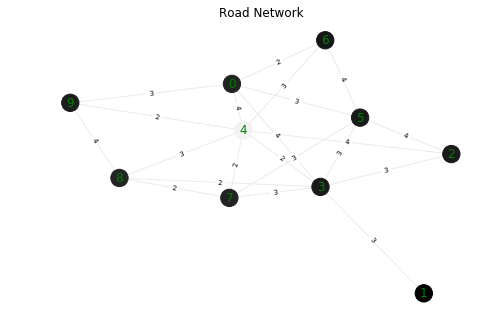

edge= 4 and j= 0


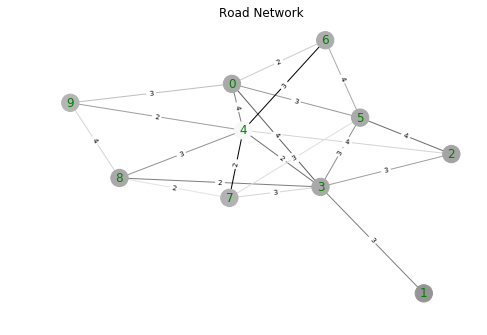

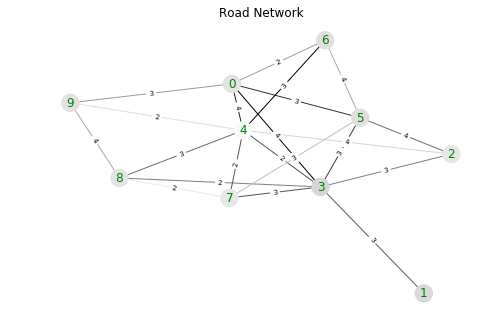

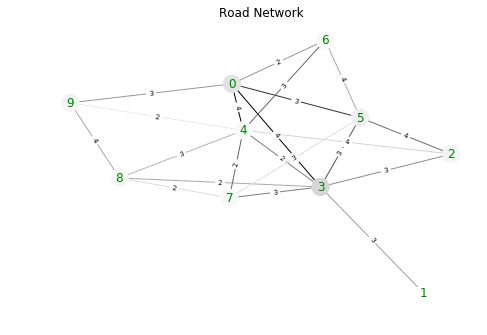

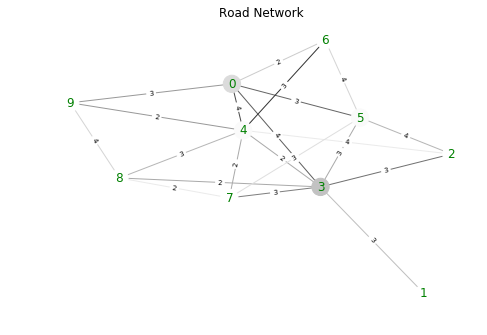

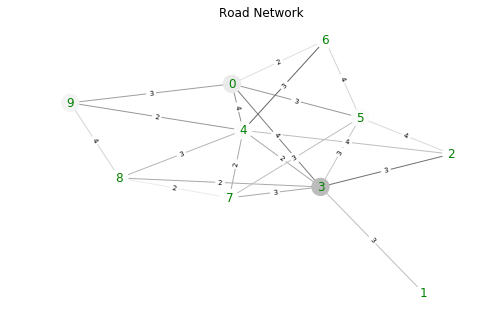

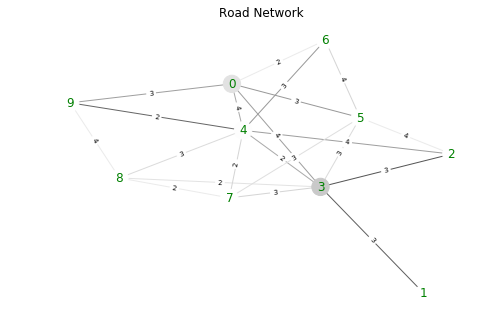

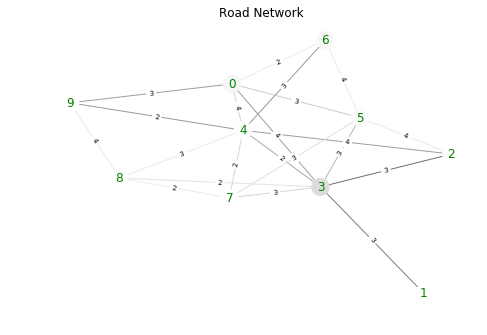

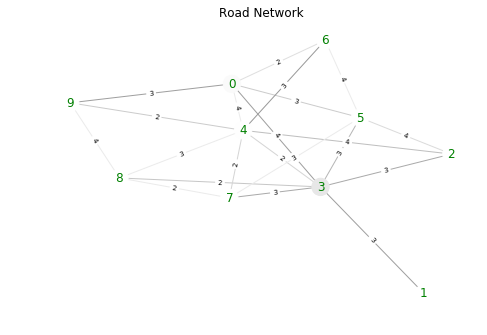

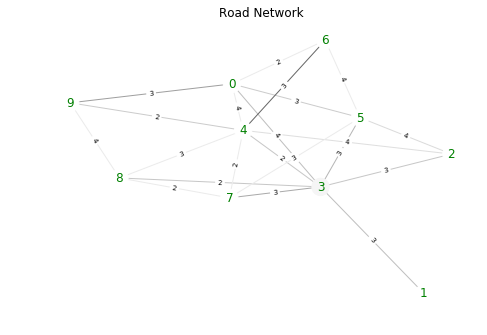

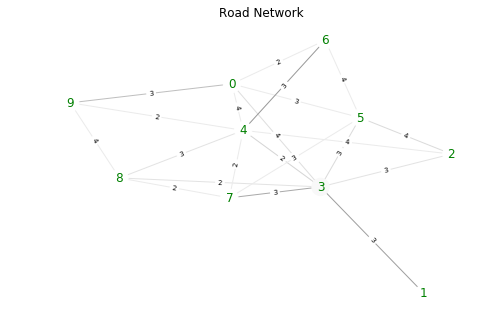

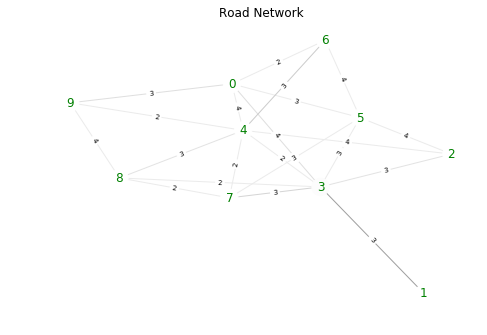

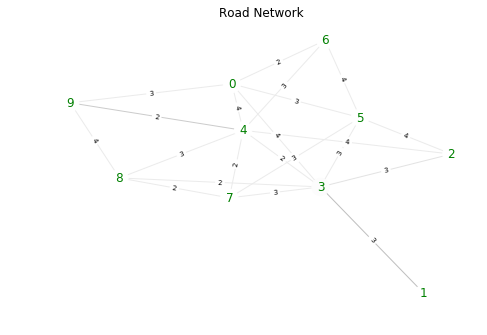

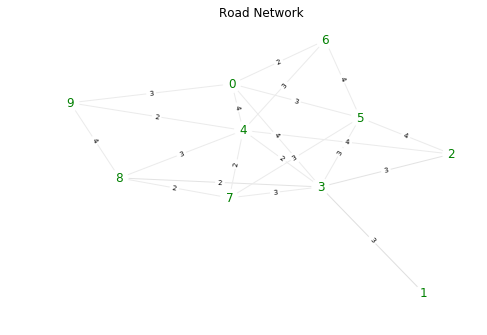

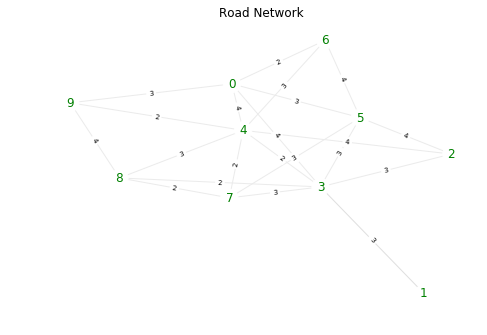

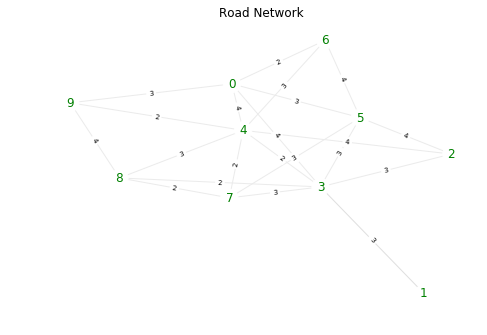

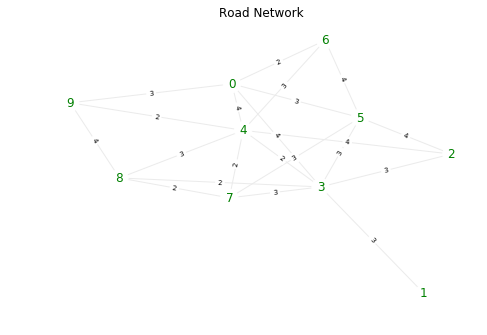

SUCCESS in 16 steps
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
Total number of packages: 176
----------
nodes_list= [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
edges_list= [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
----------
edge= 4 and j= 1


SUCCESS in 16 steps
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
Total number of packages: 167
----------
nodes_list= [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
edges_list= [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
----------
edge= 4 and j= 2


SUCCESS in 14 steps
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
Total number of packages: 166
----------
nodes_list= [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
edges_list= [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
----------
edge= 4 and j= 3


SUCCESS in 16 steps
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
Total number of packages: 169
----------
nodes_list= [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
edges_list= [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
----------
edge= 4 and j= 4


SUCCESS in 17 steps
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
Total number of packages: 164
----------
nodes_list= [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
edges_list= [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
----------
edge= 4 and j= 5


SUCCESS in 16 steps
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
Total number of packages: 180
----------
nodes_list= [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
edges_list= [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
----------
edge= 4 and j= 6


SUCCESS in 24 steps
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
Total number of packages: 173
----------
nodes_list= [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
edges_list= [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
----------
edge= 4 and j= 7


SUCCESS in 24 steps
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
Total number of packages: 163
----------
nodes_list= [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
edges_list= [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
----------
edge= 4 and j= 8


SUCCESS in 19 steps
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
Total number of packages: 153
----------
nodes_list= [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
edges_list= [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
----------
edge= 4 and j= 9


SUCCESS in 14 steps
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
Total number of packages: 160
----------
nodes_list= [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
edges_list= [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
----------
edge= 4 and j= 10


SUCCESS in 21 steps
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
Total number of packages: 164
----------
nodes_list= [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
edges_list= [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
----------
edge= 4 and j= 11


SUCCESS in 23 steps
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
Total number of packages: 176
----------
nodes_list= [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
edges_list= [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
----------
edge= 4 and j= 12


SUCCESS in 17 steps
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
Total number of packages: 170
----------
nodes_list= [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
edges_list= [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
----------
edge= 4 and j= 13


SUCCESS in 15 steps
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
Total number of packages: 168
----------
nodes_list= [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
edges_list= [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
----------
edge= 4 and j= 14


SUCCESS in 20 steps
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
Total number of packages: 175
----------
nodes_list= [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
edges_list= [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
----------
edge= 4 and j= 15


SUCCESS in 14 steps
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
Total number of packages: 167
----------
nodes_list= [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
edges_list= [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
----------
edge= 4 and j= 16


SUCCESS in 15 steps
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
Total number of packages: 167
----------
nodes_list= [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
edges_list= [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
----------
edge= 4 and j= 17


SUCCESS in 18 steps
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
Total number of packages: 180
----------
nodes_list= [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
edges_list= [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
----------
edge= 4 and j= 18


SUCCESS in 20 steps
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
Total number of packages: 169
----------
nodes_list= [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
edges_list= [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
----------
edge= 4 and j= 19


SUCCESS in 15 steps
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
Total number of packages: 166
----------
nodes_list= [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
edges_list= [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
----------
edge= 4 and j= 20


SUCCESS in 16 steps
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
Total number of packages: 174
----------
nodes_list= [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
edges_list= [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
----------
edge= 4 and j= 21


SUCCESS in 18 steps
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
Total number of packages: 172
----------
nodes_list= [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
edges_list= [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
----------
edge= 4 and j= 22


In [21]:
#------------NODES------------:

#Number of simulations used
num_of_simulations = 30
saturation = 0.9
averages = []
averages_hist = []
conf_intervals = []

#Upgrading all the nodes in the list, by multiplying their respective capacities by 8
for node_to_upgrade in [4]:
    average_steps = []
    for j in range(num_of_simulations):
        if j==0:

            #Visualize the first simulation only
            sim = Delivery_Network()
            sim.initialize(0,saturation)
            sim.double_max_num_packages(node_to_upgrade)
            sim.double_max_num_packages(node_to_upgrade)
            sim.double_max_num_packages(node_to_upgrade)
            plt.figure()
            sim.observe()
            print ("edge=", node_to_upgrade, "and j=", j)
            #Running the simulation

            while True:
                if sim.get_total()==sim.get_delivered():
                    print ("SUCCESS in", sim.get_time(), "steps")
                    average_steps.append(sim.get_time())
                    break
                sim.update()
                plt.figure()
                sim.observe()
        else:
            sim = Delivery_Network()
            sim.initialize(0,saturation)
            sim.double_max_num_packages(node_to_upgrade)
            sim.double_max_num_packages(node_to_upgrade)
            sim.double_max_num_packages(node_to_upgrade)
            print ("edge=", node_to_upgrade, "and j=", j)

            #Running the simulation
            while True:
                if sim.get_total()==sim.get_delivered():
                    print ("SUCCESS in", sim.get_time(), "steps")
                    average_steps.append(sim.get_time())
                    break
                sim.update()

    #Results:
    print ("On average:", sum(average_steps)/float(num_of_simulations), "steps are needed when we upgrade node", node_to_upgrade, "!")
    averages.append([node_to_upgrade, sum(average_steps)/float(num_of_simulations)])
    averages_hist.append(sum(average_steps)/float(num_of_simulations))
    conf_intervals.append([node_to_upgrade, [sum(average_steps)/float(num_of_simulations) - 1.96*np.std(average_steps)/float(np.sqrt(30)), sum(average_steps)/float(num_of_simulations) + 1.96*np.std(average_steps)/float(np.sqrt(30))]])


print ("Averages:")
print (averages)
print (" ")
print ("Confidence intervals:")
print (conf_intervals)

[16, 16, 14, 16, 17, 16, 24, 24, 19, 14, 21, 23, 17, 15, 20, 14, 15, 18, 20, 15, 16, 18, 21, 17, 18, 14, 16, 17, 13, 21]


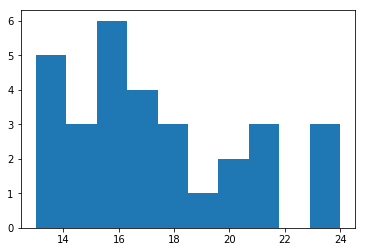

In [29]:
print (average_steps)
plt.hist(average_steps)
plt.show()

aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
Total number of packages: 181
----------
nodes_list= [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
edges_list= [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
----------


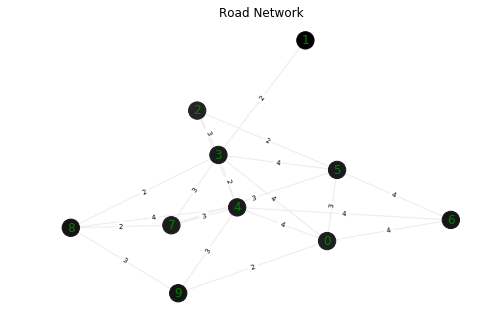

edge= 4 and j= 0


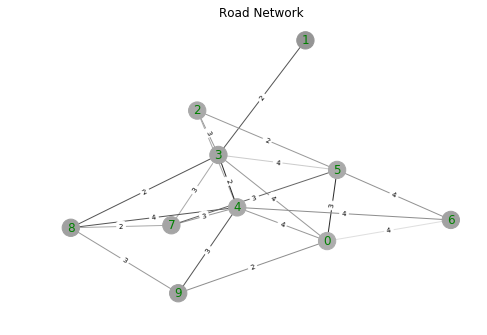

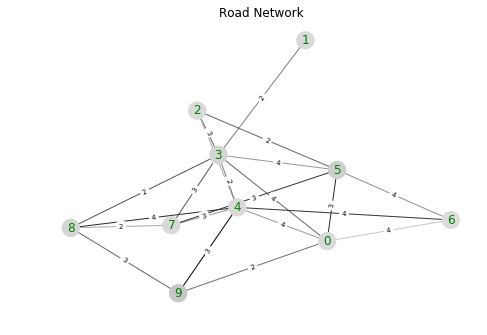

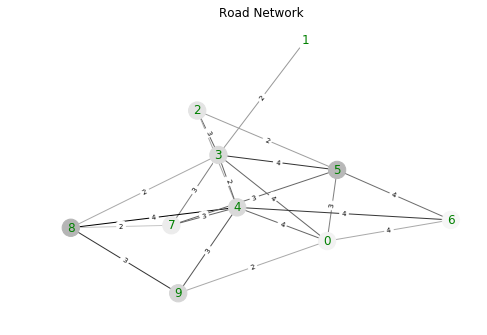

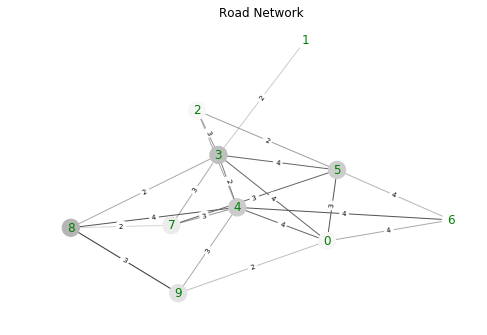

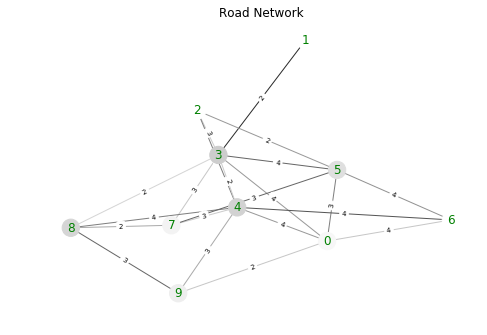

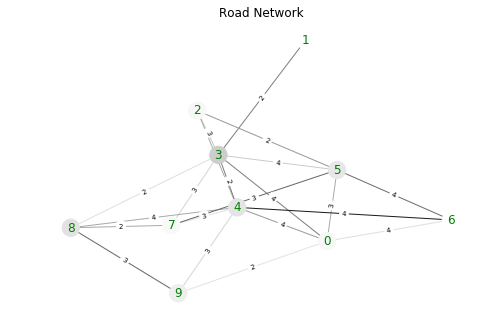

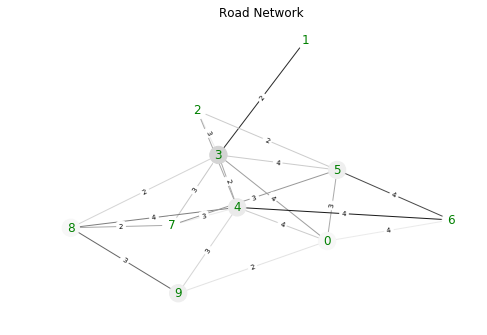

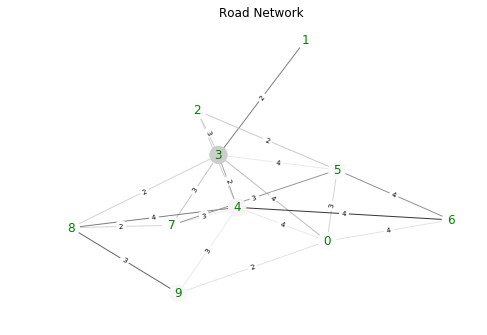

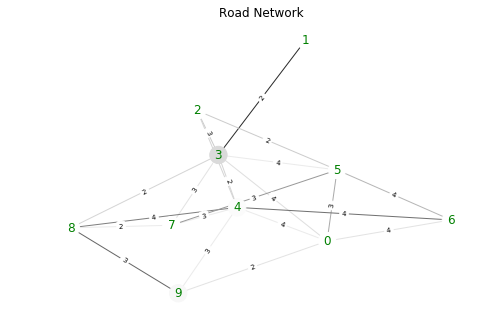

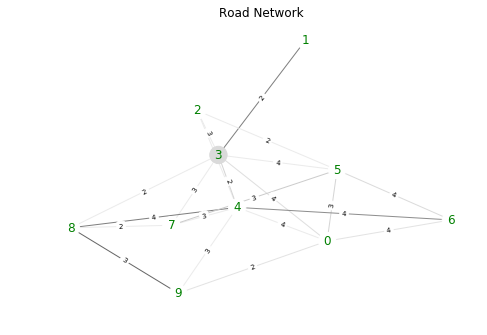

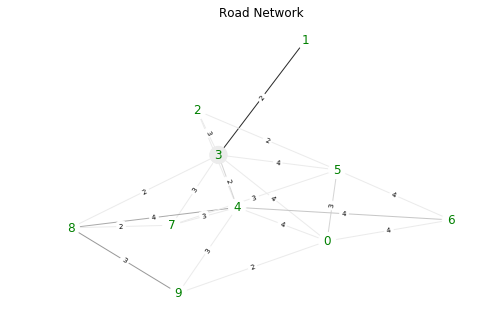

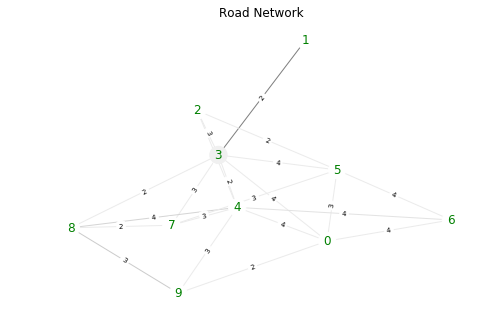

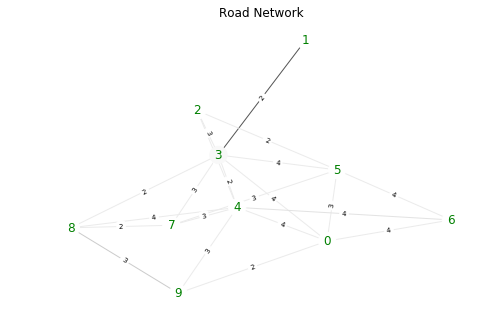

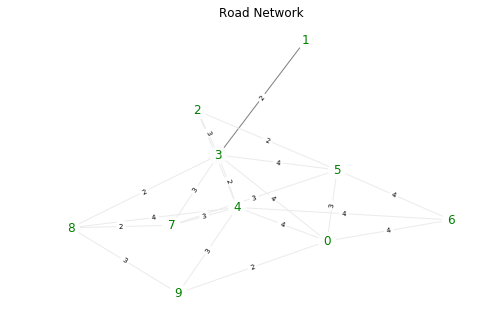

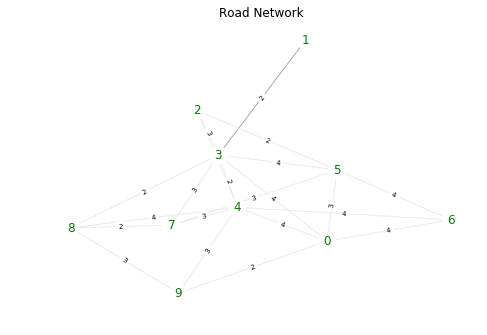

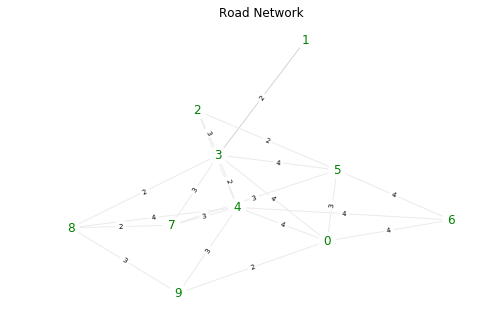

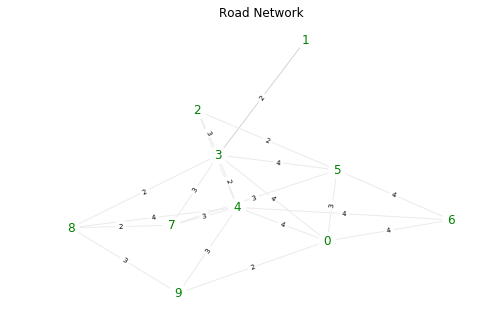

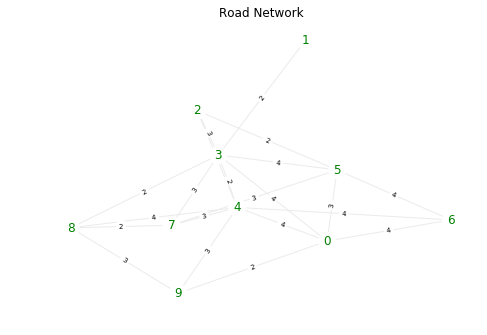

SUCCESS in 18 steps
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
Total number of packages: 161
----------
nodes_list= [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
edges_list= [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
----------
edge= 4 and j= 1


SUCCESS in 14 steps
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
Total number of packages: 159
----------
nodes_list= [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
edges_list= [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
----------
edge= 4 and j= 2


SUCCESS in 17 steps
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
Total number of packages: 173
----------
nodes_list= [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
edges_list= [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
----------
edge= 4 and j= 3


SUCCESS in 16 steps
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
Total number of packages: 170
----------
nodes_list= [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
edges_list= [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
----------
edge= 4 and j= 4


SUCCESS in 20 steps
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
Total number of packages: 168
----------
nodes_list= [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
edges_list= [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
----------
edge= 4 and j= 5


SUCCESS in 18 steps
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
Total number of packages: 173
----------
nodes_list= [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
edges_list= [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
----------
edge= 4 and j= 6


SUCCESS in 16 steps
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
Total number of packages: 165
----------
nodes_list= [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
edges_list= [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
----------
edge= 4 and j= 7


SUCCESS in 20 steps
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
Total number of packages: 170
----------
nodes_list= [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
edges_list= [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
----------
edge= 4 and j= 8


SUCCESS in 16 steps
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
Total number of packages: 173
----------
nodes_list= [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
edges_list= [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
----------
edge= 4 and j= 9


SUCCESS in 16 steps
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
Total number of packages: 173
----------
nodes_list= [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
edges_list= [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
----------
edge= 4 and j= 10


SUCCESS in 16 steps
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
Total number of packages: 159
----------
nodes_list= [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
edges_list= [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
----------
edge= 4 and j= 11


SUCCESS in 14 steps
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
Total number of packages: 159
----------
nodes_list= [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
edges_list= [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
----------
edge= 4 and j= 12


SUCCESS in 18 steps
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
Total number of packages: 177
----------
nodes_list= [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
edges_list= [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
----------
edge= 4 and j= 13


SUCCESS in 21 steps
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
Total number of packages: 180
----------
nodes_list= [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
edges_list= [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
----------
edge= 4 and j= 14


SUCCESS in 20 steps
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
Total number of packages: 173
----------
nodes_list= [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
edges_list= [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
----------
edge= 4 and j= 15


SUCCESS in 17 steps
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
Total number of packages: 161
----------
nodes_list= [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
edges_list= [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
----------
edge= 4 and j= 16


SUCCESS in 17 steps
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
Total number of packages: 168
----------
nodes_list= [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
edges_list= [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
----------
edge= 4 and j= 17


SUCCESS in 16 steps
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
Total number of packages: 168
----------
nodes_list= [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
edges_list= [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
----------
edge= 4 and j= 18


SUCCESS in 16 steps
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
Total number of packages: 164
----------
nodes_list= [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
edges_list= [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
----------
edge= 4 and j= 19


SUCCESS in 15 steps
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
Total number of packages: 179
----------
nodes_list= [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
edges_list= [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
----------
edge= 4 and j= 20


SUCCESS in 17 steps
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
Total number of packages: 162
----------
nodes_list= [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
edges_list= [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
----------
edge= 4 and j= 21


SUCCESS in 17 steps
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
aaaaa [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
bbbbb {}
ccccc {}
Total number of packages: 165
----------
nodes_list= [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
edges_list= [(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (7, 8), (8, 9)]
----------
edge= 4 and j= 22


In [19]:
#------------NOTHING------------:

#Number of simulations used
num_of_simulations = 30
saturation = 0.9
averages = []
conf_intervals = []

#Upgrading all the nodes in the list, by multiplying their respective capacities by 8
for node_to_upgrade in [4]:
    average_steps = []
    for j in range(num_of_simulations):
        if j==0:

            #Visualize the first simulation only
            sim = Delivery_Network()
            sim.initialize(0,saturation)
            #sim.double_max_num_packages(node_to_upgrade)
            #sim.double_max_num_packages(node_to_upgrade)
            #sim.double_max_num_packages(node_to_upgrade)
            plt.figure()
            sim.observe()
            print ("edge=", node_to_upgrade, "and j=", j)
            #Running the simulation

            while True:
                if sim.get_total()==sim.get_delivered():
                    print ("SUCCESS in", sim.get_time(), "steps")
                    average_steps.append(sim.get_time())
                    break
                sim.update()
                plt.figure()
                sim.observe()
        else:
            sim = Delivery_Network()
            sim.initialize(0,saturation)
            #sim.double_max_num_packages(node_to_upgrade)
            #sim.double_max_num_packages(node_to_upgrade)
            #sim.double_max_num_packages(node_to_upgrade)
            print ("edge=", node_to_upgrade, "and j=", j)

            #Running the simulation
            while True:
                if sim.get_total()==sim.get_delivered():
                    print ("SUCCESS in", sim.get_time(), "steps")
                    average_steps.append(sim.get_time())
                    break
                sim.update()

    #Results:
    print ("On average:", sum(average_steps)/float(num_of_simulations), "steps are needed when we do nothing !")
    averages.append([node_to_upgrade, sum(average_steps)/float(num_of_simulations)])
    conf_intervals.append([node_to_upgrade, [sum(average_steps)/float(num_of_simulations) - 1.96*np.std(average_steps)/float(np.sqrt(30)), sum(average_steps)/float(num_of_simulations) + 1.96*np.std(average_steps)/float(np.sqrt(30))]])


print ("Averages:")
print (averages)
print (" ")
print ("Confidence intervals:")
print (conf_intervals)